In [ ]:
#nlp final project
#malaika abbasi 
#maria ahmed


In [10]:
#imports
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [41]:
import json

def load_data_from_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def extract_data(data):
    texts = []
    emotions = []
    causes = []

    for key, value in data.items():
        if key == 'text':
            texts.append(value)
        elif key == 'emotion':
            emotions.append(value)
        elif key == 'emotion-cause_pairs':
            causes.extend(value)
        elif isinstance(value, dict):
            nested_texts, nested_emotions, nested_causes = extract_data(value)
            texts.extend(nested_texts)
            emotions.extend(nested_emotions)
            causes.extend(nested_causes)
        elif isinstance(value, list):
            for item in value:
                nested_texts, nested_emotions, nested_causes = extract_data(item)
                texts.extend(nested_texts)
                emotions.extend(nested_emotions)
                causes.extend(nested_causes)

    return texts, emotions, causes

# Load data from the first file
data1 = load_data_from_json('train1.json')

# Extract data from the first file
all_texts1, all_emotions1, all_causes1 = [], [], []
for item in data1:
    texts, emotions, causes = extract_data(item)
    all_texts1.extend(texts)
    all_emotions1.extend(emotions)
    all_causes1.extend(causes)

# Load data from the second file
data2 = load_data_from_json('train2.json')

# Extract data from the second file
all_texts2, all_emotions2, all_causes2 = [], [], []
for item in data2:
    texts, emotions, causes = extract_data(item)
    all_texts2.extend(texts)
    all_emotions2.extend(emotions)
    all_causes2.extend(causes)

# Combine the results
all_texts = all_texts1 + all_texts2
all_emotions = all_emotions1 + all_emotions2
#all_causes = all_causes1 + all_causes2
all_causes = all_causes1


In [19]:
#preprocessing data for emotion detection
tokenizer_emo = Tokenizer()
tokenizer_emo.fit_on_texts(all_texts)

sequences_emo = tokenizer_emo.texts_to_sequences(all_texts)

X_emo = pad_sequences(sequences_emo)

# Convert emotions to numerical labels for emotion detection
label_mapping_emo = {label: idx for idx, label in enumerate(set(all_emotions))}
y_emo = [label_mapping_emo[label] for label in all_emotions]

# Split the data into training and testing sets for emotion detection
X_train_emo, X_test_emo, y_train_emo, y_test_emo = train_test_split(X_emo, y_emo, test_size=0.2, random_state=42)

num_classes_emo = len(set(y_emo))

y_train_emo_one_hot = to_categorical(y_train_emo, num_classes=num_classes_emo)
y_test_emo_one_hot = to_categorical(y_test_emo, num_classes=num_classes_emo)

# Print shapes for verification
print("X_train_emo shape:", X_train_emo.shape)
print("X_test_emo shape:", X_test_emo.shape)
print("y_train_emo_one_hot shape:", y_train_emo_one_hot.shape)
print("y_test_emo_one_hot shape:", y_test_emo_one_hot.shape)


X_train_emo shape: (21790, 65)
X_test_emo shape: (5448, 65)
y_train_emo_one_hot shape: (21790, 7)
y_test_emo_one_hot shape: (5448, 7)


In [47]:
vocab_size_emo = len(tokenizer_emo.word_index) + 1

# Define the LSTM model for emotion detection
model_emo = Sequential()
model_emo.add(Embedding(input_dim=vocab_size_emo, output_dim=100, input_length=X_emo.shape[1]))
model_emo.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))) 
model_emo.add(Dense(num_classes_emo, activation='softmax'))  # 'softmax' for multiclass classification

# Compile the model
model_emo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_emo_hist = model_emo.fit(X_train_emo, y_train_emo_one_hot, epochs=50, validation_data=(X_test_emo, y_test_emo_one_hot))

# Evaluate the model
test_loss_emo, test_acc_emo = model_emo.evaluate(X_test_emo, y_test_emo_one_hot)
print(f"Test Accuracy for emotion detection: {test_acc_emo}")

Epoch 1/50
681/681 [==============================] - 197s 264ms/step - loss: 1.4345 - accuracy: 0.4821 - val_loss: 1.2812 - val_accuracy: 0.5461
Epoch 2/50
681/681 [==============================] - 215s 316ms/step - loss: 1.1306 - accuracy: 0.6022 - val_loss: 1.1749 - val_accuracy: 0.5905
Epoch 3/50
681/681 [==============================] - 147s 215ms/step - loss: 0.9393 - accuracy: 0.6733 - val_loss: 1.0897 - val_accuracy: 0.6263
Epoch 4/50
681/681 [==============================] - 238s 350ms/step - loss: 0.8102 - accuracy: 0.7180 - val_loss: 1.0301 - val_accuracy: 0.6481
Epoch 5/50
681/681 [==============================] - 189s 277ms/step - loss: 0.7160 - accuracy: 0.7487 - val_loss: 0.9962 - val_accuracy: 0.6755
Epoch 6/50
681/681 [==============================] - 186s 272ms/step - loss: 0.6532 - accuracy: 0.7683 - val_loss: 0.9691 - val_accuracy: 0.6867
Epoch 7/50
681/681 [==============================] - 183s 268ms/step - loss: 0.6020 - accuracy: 0.7869 - val_loss: 0.9495 -

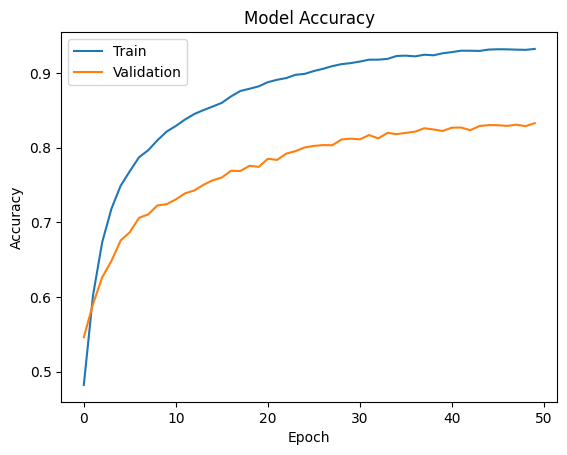

In [48]:
# Plot training & validation accuracy values
plt.plot(model_emo_hist.history['accuracy'])
plt.plot(model_emo_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
#preprocessing data for cause detection

#for part 2 of the dataset
import pandas as pd

def data2_prep():

        with open('train2.json', 'r') as file:
            data = json.load(file)

        # Initialize lists to store data
        conversation_ids = []
        utterance_ids = []
        texts = []

        # Iterate through each conversation
        for conversation in data:
            conversation_id = conversation["conversation_ID"]
            
            # Iterate through each utterance in the conversation
            for utterance in conversation["conversation"]:
                utterance_id = utterance["utterance_ID"]
                text = utterance["text"]
                
                # Append data to lists
                conversation_ids.append(conversation_id)
                utterance_ids.append(utterance_id)
                texts.append(text)

        # Create a DataFrame
        df_utterances = pd.DataFrame({
            'conversation_ID': conversation_ids,
            'utterance_ID': utterance_ids,
            'text': texts
        })

        # Initialize lists to store data
        conversation_ids = []
        emotions = []
        causes = []

        # Iterate through each conversation
        for conversation in data:
            conversation_id = conversation["conversation_ID"]
            
            # Iterate through each emotion-cause pair in the conversation
            for pair in conversation["emotion-cause_pairs"]:
                emotion, cause = pair[0].split('_'), pair[1]
                conversation_ids.append(conversation_id)
                emotions.append(emotion)
                causes.append(cause)

        # Create a DataFrame for emotion-cause pairs
        df_pairs = pd.DataFrame({
            'conversation_ID': conversation_ids,
            'emotion': [emotion[1] for emotion in emotions],
            'cause': causes
        })

        # Merge tables based on conversation_ID
        merged_df = pd.merge(df_pairs, df_utterances, on='conversation_ID', how='left')

        # Convert 'cause' column to int for matching
        merged_df['cause'] = merged_df['cause'].astype(int)

        # Extract text corresponding to cause
        merged_df['cause_text'] = merged_df.apply(lambda row: row['text'] if row['cause'] == row['utterance_ID'] else None, axis=1)

        # Merge tables based on conversation_ID
        merged_df = pd.merge(df_pairs, df_utterances[['conversation_ID', 'utterance_ID', 'text']], on='conversation_ID', how='left')

        # Convert 'cause' column to int for matching
        merged_df['cause'] = merged_df['cause'].astype(int)

        # Extract text corresponding to cause
        merged_df['cause_text'] = merged_df.apply(lambda row: row['text'] if row['cause'] == row['utterance_ID'] else None, axis=1)

        # Drop unnecessary columns
        merged_df.drop(['text'], axis=1, inplace=True)
        merged_df.drop(['conversation_ID'], axis=1, inplace=True)
        merged_df.drop(['cause'], axis=1, inplace=True)

        # Drop rows with null values in 'cause_text' column
        merged_df = merged_df.dropna(subset=['cause_text'])

        emotion_list = merged_df['emotion'].tolist()
        cause_text_list = merged_df['cause_text'].tolist()

        return emotion_list, cause_text_list




In [55]:
more_emo, more_cause = data2_prep()

# Process the causes
processed_causes = [(cause[0].split('_')[1], cause[1].split('_', 1)[1]) for cause in all_causes]

all_texts_causes = [cause[1] for cause in processed_causes]
all_emotions_causes = [cause[0] for cause in processed_causes]

all_texts_causes = all_texts_causes + more_cause
all_emotions_causes = all_emotions_causes + more_emo 

tokenizer_causes = Tokenizer()
tokenizer_causes.fit_on_texts(all_texts_causes)

sequences_causes = tokenizer_causes.texts_to_sequences(all_texts_causes)

X_causes = pad_sequences(sequences_causes)

label_mapping_causes = {label: idx for idx, label in enumerate(set(all_emotions_causes))}
y_causes = [label_mapping_causes[label] for label in all_emotions_causes]

X_train_causes, X_test_causes, y_train_causes, y_test_causes = train_test_split(X_causes, y_causes, test_size=0.2, random_state=42)

# Print shapes for verification
print("X_train_causes shape:", X_train_causes.shape)
print("X_test_causes shape:", X_test_causes.shape)
print("y_train_causes shape:", len(y_train_causes))
print("y_test_causes shape:", len(y_test_causes))



X_train_causes shape: (15326, 65)
X_test_causes shape: (3832, 65)
y_train_causes shape: 15326
y_test_causes shape: 3832


In [56]:
vocab_size_causes = len(tokenizer_causes.word_index) + 1
num_classes_causes = len(set(y_causes))

y_train_causes_one_hot = to_categorical(y_train_causes, num_classes=num_classes_causes)
y_test_causes_one_hot = to_categorical(y_test_causes, num_classes=num_classes_causes)

# Print shapes for verification
print("X_train_causes shape:", X_train_causes.shape)
print("X_test_causes shape:", X_test_causes.shape)
print("y_train_causes_one_hot shape:", y_train_causes_one_hot.shape)
print("y_test_causes_one_hot shape:", y_test_causes_one_hot.shape)

X_train_causes shape: (15326, 65)
X_test_causes shape: (3832, 65)
y_train_causes_one_hot shape: (15326, 6)
y_test_causes_one_hot shape: (3832, 6)


In [57]:
# Define the model for cause detection
model_causes = Sequential()
model_causes.add(Embedding(input_dim=vocab_size_causes, output_dim=100, input_length=X_causes.shape[1]))
model_causes.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))  # Add dropout here  # Use return_sequences=True to get the sequence output

model_causes.add(Dense(num_classes_causes, activation='softmax'))  # Use 'softmax' for multiclass classification

# Compile the model
model_causes.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_cause_hist = model_causes.fit(X_train_causes, y_train_causes_one_hot, epochs=25, validation_data=(X_test_causes, y_test_causes_one_hot))


Epoch 1/25
479/479 [==============================] - 270s 457ms/step - loss: 1.4647 - accuracy: 0.3989 - val_loss: 1.2886 - val_accuracy: 0.5097
Epoch 2/25
479/479 [==============================] - 180s 376ms/step - loss: 1.1341 - accuracy: 0.5820 - val_loss: 1.1558 - val_accuracy: 0.5731
Epoch 3/25
479/479 [==============================] - 135s 281ms/step - loss: 0.9406 - accuracy: 0.6562 - val_loss: 1.0901 - val_accuracy: 0.6031
Epoch 4/25
479/479 [==============================] - 173s 361ms/step - loss: 0.8244 - accuracy: 0.6948 - val_loss: 1.0715 - val_accuracy: 0.6143
Epoch 5/25
479/479 [==============================] - 139s 289ms/step - loss: 0.7479 - accuracy: 0.7183 - val_loss: 1.0518 - val_accuracy: 0.6315
Epoch 6/25
479/479 [==============================] - 149s 311ms/step - loss: 0.6916 - accuracy: 0.7341 - val_loss: 1.0286 - val_accuracy: 0.6399
Epoch 7/25
479/479 [==============================] - 145s 302ms/step - loss: 0.6485 - accuracy: 0.7473 - val_loss: 1.0154 -

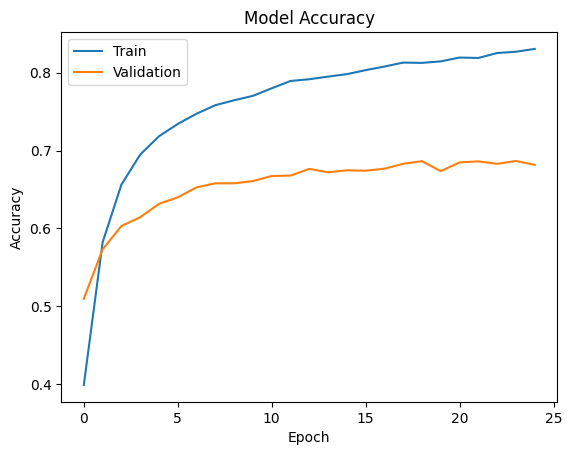

In [59]:

# Plot training & validation accuracy values
plt.plot(model_cause_hist.history['accuracy'])
plt.plot(model_cause_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [60]:
# Evaluate the model
test_loss_causes, test_acc_causes = model_causes.evaluate(X_test_causes, y_test_causes_one_hot)
print(f"Test Accuracy for cause detection: {test_acc_causes}")

120/120 [==============================] - 5s 44ms/step - loss: 1.1946 - accuracy: 0.6816
Test Accuracy for cause detection: 0.681628406047821
